# Importing necessary libraries and setting up the environment

In [5]:
from google.colab import files

uploaded = files.upload()


Saving kaggle (1).json to kaggle (1).json


In [8]:
!rm -rf ~/.kaggle


In [12]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


# Downloading the dataset from Kaggle and unzipping it

In [ ]:
!kaggle datasets download -d 'risangbaskoro/wlasl-processed'


In [ ]:
!unzip wlasl-processed.zip


# Installing required packages

In [ ]:
!pip install mediapipe opencv-python


In [ ]:
import json
import os

# Path to the JSON file containing metadata
json_path = '/content/WLASL_v0.3.json'

# Load the dataset metadata
with open(json_path) as f:
    asl_data = json.load(f)

# Example to print the first entry
print(asl_data[0])


# Preprocessing videos by extracting hand landmarks

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
import random
import pickle

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=1,
                       min_detection_confidence=0.5,
                       min_tracking_confidence=0.5)

def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_landmarks = []  # List to store landmarks of each frame

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        # Extract landmarks if any are detected
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Extracting x, y coordinates of landmarks for each hand
                landmarks = [(lm.x, lm.y) for lm in hand_landmarks.landmark]
                frame_landmarks.append(landmarks)

    cap.release()
    return frame_landmarks

def save_landmarks(landmarks, filename):
    with open(filename, 'wb') as f:
        pickle.dump(landmarks, f)

def process_subset_of_videos(directory, sample_size=500):
    video_files = [f for f in os.listdir(directory) if f.endswith(".mp4")]
    sampled_files = random.sample(video_files, min(sample_size, len(video_files)))  # Ensure we don't sample more than exists
    all_landmarks = {}

    for filename in sampled_files:
        video_path = os.path.join(directory, filename)
        landmarks = preprocess_video(video_path)
        all_landmarks[filename] = landmarks
        print(f"Processed {filename}: {len(landmarks)} frames processed.")

    # Save all landmarks to a file
    save_landmarks(all_landmarks, 'processed_landmarks.pkl')

# Set the directory containing your videos
video_directory = '/content/videos'
process_subset_of_videos(video_directory, sample_size=500)  # Adjust sample size as needed


In [28]:
def load_landmarks(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Load the processed landmarks
landmarks_data = load_landmarks('processed_landmarks.pkl')


#Flatten and normalize landmarks data

In [32]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def flatten_and_normalize_landmarks(landmarks_dict):
    flattened_features = []
    for video_name, frames in landmarks_dict.items():
        for frame_landmarks in frames:
            # Flatten landmarks for each frame
            flat_landmarks = np.array(frame_landmarks).flatten().reshape(-1, 1)
            normalized_landmarks = scaler.fit_transform(flat_landmarks).flatten()
            flattened_features.append(normalized_landmarks)
    return flattened_features

# Assuming 'landmarks_data' is your loaded data from pickle
flattened_features = flatten_and_normalize_landmarks(landmarks_data)


# Matching labels with processed videos

In [ ]:
import json

def load_metadata(metadata_path):
    with open(metadata_path, 'r') as file:
        return json.load(file)

def extract_labels(metadata):
    labels_mapping = {}
    for entry in metadata:
        gloss = entry['gloss']
        for instance in entry['instances']:
            video_id = instance['video_id']
            labels_mapping[video_id + '.mp4'] = gloss
    return labels_mapping

def match_labels(processed_videos, labels_mapping):
    return {video: labels_mapping.get(video, 'Unknown') for video in processed_videos}

# Paths and dataa
metadata_path = '/content/WLASL_v0.3.json'

# List of processed videos, hardcoded for convenience
processed_videos = [
"35120.mp4", "07451.mp4", "07372.mp4", "00416.mp4", "54298.mp4", "19561.mp4", "43255.mp4", "12231.mp4", "41079.mp4", "23434.mp4",
"08917.mp4", "16986.mp4", "24344.mp4", "66708.mp4", "56775.mp4", "06047.mp4", "36404.mp4", "34839.mp4", "19971.mp4", "55421.mp4",
"25068.mp4", "66596.mp4", "33986.mp4", "66284.mp4", "09892.mp4", "21923.mp4", "05095.mp4", "53270.mp4", "66486.mp4", "54667.mp4",
"20381.mp4", "26931.mp4", "08347.mp4", "13228.mp4", "12656.mp4", "57060.mp4", "49383.mp4", "07472.mp4", "58026.mp4", "04509.mp4",
"36933.mp4", "66555.mp4", "24525.mp4", "51709.mp4", "05743.mp4", "07269.mp4", "33808.mp4", "65832.mp4", "47440.mp4", "49805.mp4",
"04013.mp4", "69316.mp4", "13695.mp4", "34005.mp4", "20070.mp4", "37308.mp4", "59214.mp4", "52615.mp4", "36402.mp4", "65950.mp4",
"13273.mp4", "60462.mp4", "31496.mp4", "21568.mp4", "40469.mp4", "43931.mp4", "57077.mp4", "45111.mp4", "47001.mp4", "32759.mp4",
"20158.mp4", "42246.mp4", "65591.mp4", "51918.mp4", "12874.mp4", "57728.mp4", "05912.mp4", "03805.mp4", "04619.mp4", "58911.mp4",
"41941.mp4", "18246.mp4", "65464.mp4", "17325.mp4", "66228.mp4", "20987.mp4", "53015.mp4", "52201.mp4", "04325.mp4", "56344.mp4",
"09634.mp4", "50014.mp4", "01158.mp4", "40115.mp4", "11260.mp4", "14467.mp4", "24682.mp4", "34276.mp4", "35574.mp4", "00603.mp4",
"53709.mp4", "62393.mp4", "14887.mp4", "00963.mp4", "00868.mp4", "26574.mp4", "49436.mp4", "01583.mp4", "53872.mp4", "08588.mp4",
"21370.mp4", "08862.mp4", "00435.mp4", "15813.mp4", "47846.mp4", "59249.mp4", "64308.mp4", "53546.mp4", "47913.mp4", "44843.mp4",
"02864.mp4", "58665.mp4", "51107.mp4", "65131.mp4", "07492.mp4", "66423.mp4", "25508.mp4", "13173.mp4", "50855.mp4", "06021.mp4",
"41645.mp4", "18944.mp4", "20513.mp4", "66791.mp4", "41055.mp4", "14734.mp4", "65226.mp4", "48731.mp4", "57640.mp4", "51226.mp4",
"16386.mp4", "14202.mp4", "03479.mp4", "65518.mp4", "44953.mp4", "37613.mp4", "02092.mp4", "56178.mp4", "44402.mp4", "37194.mp4",
"44321.mp4", "53565.mp4", "27099.mp4", "10449.mp4", "59596.mp4", "28818.mp4", "40566.mp4", "08612.mp4", "05175.mp4", "40987.mp4",
"24043.mp4", "10300.mp4", "05090.mp4", "46780.mp4", "41317.mp4", "69286.mp4", "26945.mp4", "39291.mp4", "66818.mp4", "63851.mp4",
"22974.mp4", "64065.mp4", "27154.mp4", "35523.mp4", "02712.mp4", "44683.mp4", "50143.mp4", "48341.mp4", "65235.mp4", "62619.mp4",
"53644.mp4", "38399.mp4", "10581.mp4", "18315.mp4", "21694.mp4", "11529.mp4", "20262.mp4", "09186.mp4", "43388.mp4", "66731.mp4",
"25191.mp4", "00904.mp4", "60385.mp4", "66303.mp4", "66155.mp4", "21086.mp4", "09305.mp4", "64043.mp4", "38181.mp4", "24946.mp4",
"08746.mp4", "05767.mp4", "01471.mp4", "43373.mp4", "45419.mp4", "49334.mp4", "05232.mp4", "18028.mp4", "59073.mp4", "32511.mp4",
"23407.mp4", "36687.mp4", "35513.mp4", "50584.mp4", "06001.mp4", "69489.mp4", "47307.mp4", "64385.mp4", "44779.mp4", "61443.mp4",
"53771.mp4", "13249.mp4", "28582.mp4", "65535.mp4", "05685.mp4", "65168.mp4", "47237.mp4", "02852.mp4", "06049.mp4", "62782.mp4",
"08308.mp4", "65781.mp4", "07433.mp4", "66016.mp4", "43058.mp4", "66800.mp4", "26856.mp4", "09625.mp4", "03235.mp4", "32522.mp4",
"34123.mp4", "60350.mp4", "49640.mp4", "03068.mp4", "21945.mp4", "52318.mp4", "24044.mp4", "60948.mp4", "03121.mp4", "54995.mp4",
"34357.mp4", "57238.mp4", "57302.mp4", "28261.mp4", "22636.mp4", "53855.mp4", "50618.mp4", "58834.mp4", "17949.mp4", "05920.mp4",
"17821.mp4", "51356.mp4", "43594.mp4", "13751.mp4", "26013.mp4", "08745.mp4", "27450.mp4", "27775.mp4", "21829.mp4", "01252.mp4",
"28376.mp4", "06313.mp4", "65504.mp4", "59846.mp4", "23585.mp4", "22412.mp4", "60221.mp4", "60305.mp4", "65428.mp4", "19766.mp4",
"60460.mp4", "06655.mp4", "41165.mp4", "54805.mp4", "53295.mp4", "66280.mp4", "54260.mp4", "17364.mp4", "11711.mp4", "50938.mp4",
"66484.mp4", "09849.mp4", "63789.mp4", "29648.mp4", "44544.mp4", "19930.mp4", "08536.mp4", "06628.mp4", "65607.mp4", "65140.mp4",
"41822.mp4", "53220.mp4", "13460.mp4", "02625.mp4", "43946.mp4", "22926.mp4", "52712.mp4", "56840.mp4", "48346.mp4", "16002.mp4",
"45261.mp4", "08474.mp4", "18875.mp4", "50503.mp4", "02542.mp4", "53881.mp4", "20445.mp4", "09306.mp4", "44221.mp4", "38396.mp4",
"04099.mp4", "45912.mp4", "32562.mp4", "38841.mp4", "01226.mp4", "52049.mp4", "57850.mp4", "19409.mp4", "15547.mp4", "65204.mp4",
"17298.mp4", "03061.mp4", "37046.mp4", "65752.mp4", "17087.mp4", "25246.mp4", "13468.mp4", "50319.mp4", "06833.mp4", "34266.mp4",
"12391.mp4", "52320.mp4", "54823.mp4", "26537.mp4", "03605.mp4", "13880.mp4", "04062.mp4", "15849.mp4", "50122.mp4", "27635.mp4",
"63077.mp4", "05631.mp4", "23667.mp4", "32569.mp4", "10106.mp4", "07772.mp4", "05792.mp4", "49084.mp4", "13859.mp4", "54124.mp4",
"20142.mp4", "69262.mp4", "05110.mp4", "63499.mp4", "55535.mp4", "57709.mp4", "12314.mp4", "44782.mp4", "32398.mp4", "62196.mp4",
"53154.mp4", "35453.mp4", "26531.mp4", "60915.mp4", "57657.mp4", "39881.mp4", "38378.mp4", "44831.mp4", "15907.mp4", "61368.mp4",
"13161.mp4", "27634.mp4", "10186.mp4", "66557.mp4", "16892.mp4", "43812.mp4", "54139.mp4", "00599.mp4", "17758.mp4", "51276.mp4",
"17827.mp4", "03105.mp4", "10687.mp4", "01926.mp4", "53367.mp4", "55803.mp4", "34577.mp4", "62756.mp4", "07506.mp4", "26800.mp4",
"38830.mp4", "26494.mp4", "36040.mp4", "52556.mp4", "54081.mp4", "32284.mp4", "04290.mp4", "06976.mp4", "10008.mp4", "55000.mp4",
"10711.mp4", "25623.mp4", "65472.mp4", "06045.mp4", "17762.mp4", "17206.mp4", "57134.mp4", "66515.mp4", "36146.mp4", "05808.mp4",
"27456.mp4", "59966.mp4", "24438.mp4", "07475.mp4", "57170.mp4", "48573.mp4", "09574.mp4", "27925.mp4", "49175.mp4", "33651.mp4",
"05873.mp4", "55368.mp4", "64283.mp4", "05778.mp4", "20973.mp4", "57825.mp4", "26527.mp4", "46173.mp4", "11563.mp4", "57671.mp4",
"18289.mp4", "56488.mp4", "15176.mp4", "32959.mp4", "37126.mp4", "28469.mp4", "58937.mp4", "19224.mp4", "03272.mp4", "52802.mp4",
"32214.mp4", "69546.mp4", "12680.mp4", "01564.mp4", "25624.mp4", "35555.mp4", "39507.mp4", "44538.mp4", "53267.mp4", "08429.mp4",
"05217.mp4", "42553.mp4", "58664.mp4", "18759.mp4", "44563.mp4", "22003.mp4", "28454.mp4", "65782.mp4", "44083.mp4", "39996.mp4",
"04202.mp4", "56160.mp4", "69352.mp4", "49328.mp4", "65244.mp4", "66088.mp4", "27190.mp4", "30676.mp4", "13619.mp4", "50415.mp4",
"44274.mp4", "19816.mp4", "16585.mp4", "66765.mp4", "48566.mp4", "50534.mp4", "10703.mp4", "12116.mp4", "62524.mp4", "00377.mp4",
"66758.mp4", "57771.mp4", "08417.mp4", "43529.mp4", "42567.mp4", "35966.mp4", "19692.mp4", "54955.mp4", "66263.mp4", "31898.mp4"
]

# Load and process data
metadata = load_metadata(metadata_path)
labels_mapping = extract_labels(metadata)
matched_labels = match_labels(processed_videos, labels_mapping)

# Output the matched labels
for video, label in matched_labels.items():
    print(f"{video}: {label}")


# Defining a function to flatten and normalize landmarks data with labels mapping

In [39]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Assuming landmarks_data is loaded and you have a correct labels mapping
def flatten_and_normalize_landmarks(landmarks_dict, labels_mapping):
    flattened_features = []
    matched_labels = []
    scaler = MinMaxScaler()

    for video_name, frames in landmarks_dict.items():
        if video_name in labels_mapping:  # Ensure there is a label for the video
            for frame_landmarks in frames:
                # Flatten landmarks for each frame
                flat_landmarks = np.array(frame_landmarks).flatten().reshape(-1, 1)
                normalized_landmarks = scaler.fit_transform(flat_landmarks).flatten()
                flattened_features.append(normalized_landmarks)
                matched_labels.append(labels_mapping[video_name])

    return flattened_features, matched_labels

# Load metadata and prepare labels mapping
metadata = load_metadata('/content/WLASL_v0.3.json')
labels_mapping = extract_labels(metadata)

# Generate features and labels
flattened_features, final_labels = flatten_and_normalize_landmarks(landmarks_data, labels_mapping)

# Encoding labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(final_labels)

# Splitting the dataset
X_train, X_val, y_train, y_val = train_test_split(flattened_features, encoded_labels, test_size=0.2, random_state=42)


In [41]:
# Convert lists to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)

# Now that X_train and X_val are numpy arrays, you can safely access .shape and other numpy methods


# Defining the neural network model architecture

Epoch 1/50
517/518 [============================>.] - ETA: 0s - loss: 5.3360 - accuracy: 0.0432

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


518/518 [==============================] - 19s 29ms/step - loss: 5.3358 - accuracy: 0.0431 - val_loss: 4.2057 - val_accuracy: 0.1609 - lr: 0.0010
Epoch 2/50
518/518 [==============================] - 13s 25ms/step - loss: 3.7286 - accuracy: 0.2064 - val_loss: 3.2173 - val_accuracy: 0.3163 - lr: 0.0010
Epoch 3/50
518/518 [==============================] - 11s 21ms/step - loss: 3.0104 - accuracy: 0.3284 - val_loss: 2.6601 - val_accuracy: 0.4166 - lr: 0.0010
Epoch 4/50
518/518 [==============================] - 12s 23ms/step - loss: 2.5562 - accuracy: 0.4104 - val_loss: 2.2854 - val_accuracy: 0.5058 - lr: 0.0010
Epoch 5/50
518/518 [==============================] - 11s 22ms/step - loss: 2.2463 - accuracy: 0.4747 - val_loss: 2.0543 - val_accuracy: 0.5522 - lr: 0.0010
Epoch 6/50
518/518 [==============================] - 6s 12ms/step - loss: 2.0255 - accuracy: 0.5202 - val_loss: 1.8935 - val_accuracy: 0.5761 - lr: 0.0010
Epoch 7/50
518/518 [==============================] - 8s 16ms/step - l

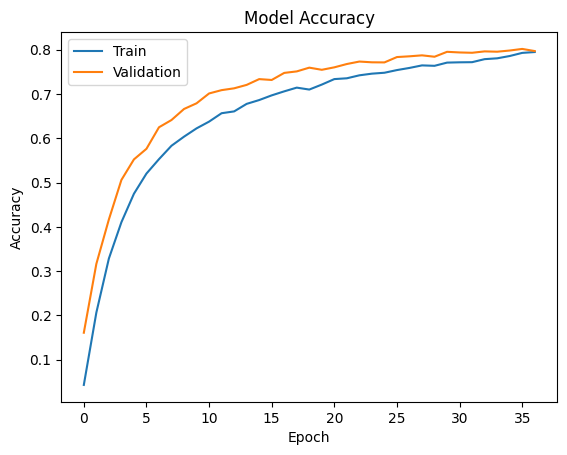

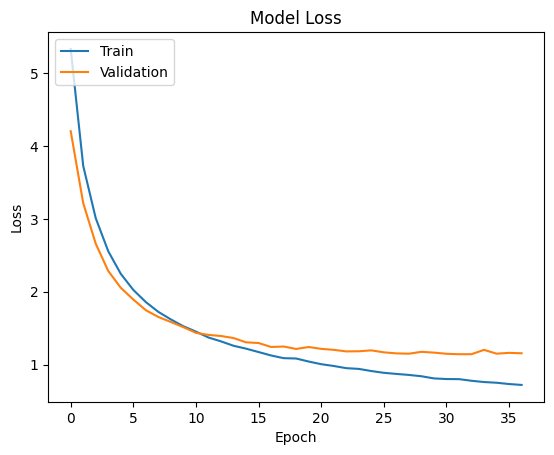

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define the model
model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')  # Output layer with one neuron per class
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping criteria
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Train the model with the new callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Increased number of epochs to allow for more training iterations
    batch_size=32,
    callbacks=[early_stopper, checkpoint, reduce_lr]
)

# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [55]:
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, Dense, Input, Dropout, LayerNormalization, GlobalAveragePooling1D, Embedding
from tensorflow.keras.models import Model
import tensorflow_addons as tfa


# Defining a transformer encoder function

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 42)]                 0         []                            
                                                                                                  
 dense_15 (Dense)            (None, 128)                  5504      ['input_4[0][0]']             
                                                                                                  
 dropout_8 (Dropout)         (None, 128)                  0         ['dense_15[0][0]']            
                                                                                                  
 layer_normalization_7 (Lay  (None, 128)                  256       ['dropout_8[0][0]']           
 erNormalization)                                                                           

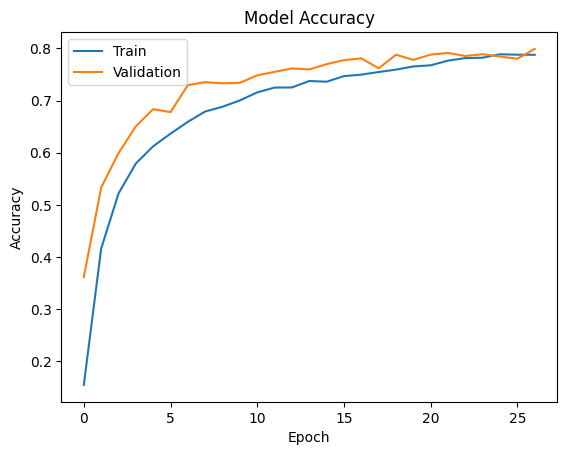

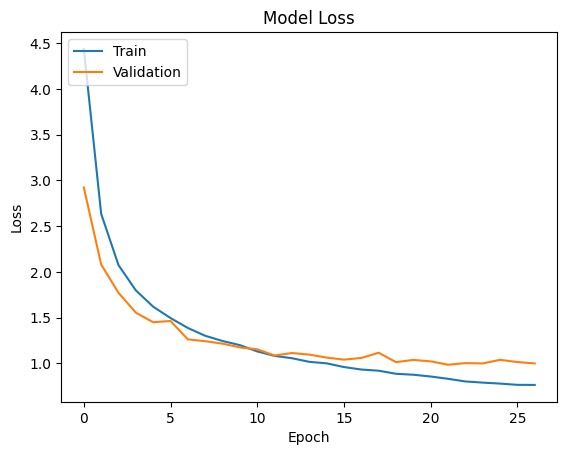

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization and Multi-head attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed-forward network
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Model input
input_shape = (X_train.shape[1],)  # Update based on your input feature preparation
inputs = Input(shape=input_shape)

# Expand dimensions for Transformer processing
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.1)(x)
x = LayerNormalization(epsilon=1e-6)(x)
x = tf.expand_dims(x, axis=1)  # Add the sequence dimension for Transformer

# Transformer encoder
transformer_output = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
transformer_output = Flatten()(transformer_output)  # Flatten the output for the Dense layer

# Output layer
outputs = Dense(len(np.unique(y_train)), activation='softmax')(transformer_output)

# Compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Callbacks
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_transformer_model.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Adjust the number of epochs based on your training dynamics
    batch_size=32,
    callbacks=[early_stopper, checkpoint, reduce_lr]
)

# Plotting
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
